In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR

In [2]:
#Data Preprocessing
df= pd.read_csv("./prices-split-adjusted.csv")
symbols = df['symbol'].unique()
google = df.loc[df['symbol'] == 'GOOG']
closing = google[['close']]
dates = google[['date']]
metrics = google.drop(['symbol','close','date'],axis=1)

In [3]:
#Split Training and Test Set
features = metrics.as_matrix()
augmented = np.ones((1762,5))
for i in range(0,1762):
    for j in range(0,4):
        augmented[i,j] = features[i,j]
        
closingPrice = closing.as_matrix()
closingValues = np.zeros((1762,1))
for i in range(0,1762):
    closingValues[i,0] = closingPrice[i,0]
    
train = augmented[0:1322]
closingTrain = closingValues[0:1322]
test = augmented[1322:1762]
closingTest = closingValues[1322:1762]
trainDates = dates[0:1322]
testDates = dates[1322:1762]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [4]:
#Least Squares Regression
train_T = train.T
w_LS = np.matmul((np.matmul(np.linalg.inv(np.matmul(train_T,train)),train_T)),closingTrain)
y_pred = test @ w_LS
error = np.linalg.norm(y_pred-closingTest,2)
print(error)

74.13522664114898


In [5]:
#Calculate w for training set- LS Regression
def LSRegression(trainData,trainLabels):
    leastSquares = ((np.linalg.inv(trainData.T@trainData)@trainData.T)@trainLabels)
    y_hat = trainData@leastSquares
    return leastSquares
print(LSRegression(train,closingTrain))

[[-5.75766695e-01]
 [ 7.99770061e-01]
 [ 7.77560048e-01]
 [ 2.84275075e-08]
 [-4.98542843e-01]]


In [6]:
#Compute Least Squares Error
def LSError(actual,predicted):
    error = np.linalg.norm(actual-predicted,2)**2
    return error
pred = train@LSRegression(train,closingTrain)
print(LSError(closingTrain,pred))

5182.294949902059


21.177198897654193

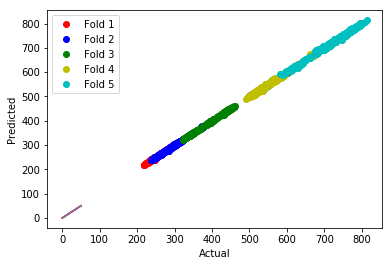

In [7]:
def LeastSquares_CV(trainData,trainLabels,folds):
    #Split training data and training labels
    splitData = np.array_split(trainData,folds)
    splitLabels = np.array_split(trainLabels,folds)
    predError = 0
    colorList = ['ro','bo','go','yo','co']
    labels = ['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5']
    #Cross Validation
    for i in range(folds):
        dataset = list()
        dataLabels = list()
        #Test Set
        testData = splitData[i]
        testLabels = splitLabels[i]
        for j in range(folds):
            if(i==j):
                continue
            dataset.extend(splitData[j])
            dataLabels.extend(splitLabels[j])
        dataset = np.asarray(dataset)
        dataLabels = np.asarray(dataLabels)
        
        #Compute w_hat and y_hat for test set
        w_hat = LSRegression(dataset,dataLabels)
        predicted = testData@w_hat
        error = LSError(testLabels, predicted)
        
        #Avg Error
        predError = predError + error
        plt.plot(testLabels,predicted,colorList[i],label = labels[i])
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        #Line with slope=1
        x = np.linspace(0,50,100)
        y = x
        plt.plot(x,y)
        avgError = predError/506
    plt.legend()
    return avgError

LeastSquares_CV(augmented,closingPrice,5)

In [8]:
#Calculate w for training set- Ridge Regression
def RidgeRegression(trainData,trainLabels,regParam):
    ridgeA = np.linalg.inv(trainData.T@trainData)
    identity = np.identity(len(ridgeA))
    ridge = np.linalg.inv(trainData.T@trainData + (regParam*identity))@trainData.T@trainLabels
    return ridge
w_rr = RidgeRegression(train,closingTrain,.01)
y = train @ w_rr

In [9]:
#Compute Ridge Regression Error
def RidgeError(actual,predicted):
    error = np.linalg.norm(actual-predicted,2)**2
    return error
RidgeError(closingTrain,y)

5182.294950438639

21.17551437703888

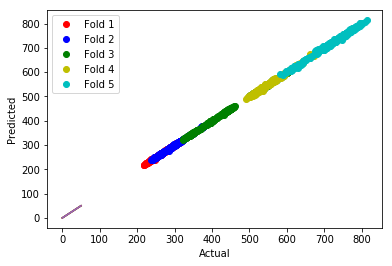

In [12]:
def RR_CV(coefficients,actual,folds,regParam):
    #Split training data and training labels
    splitData = np.array_split(coefficients,folds)
    splitLabels = np.array_split(actual,folds)
    predError = 0
    colorList = ['ro','bo','go','yo','co']
    labels = ['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5']
    #Cross Validation
    for i in range(folds):
        dataset = list()
        dataLabels = list()
        #Test Set
        testData = splitData[i]
        testLabels = splitLabels[i]
        for j in range(folds):
            if(i==j):
                continue
            dataset.extend(splitData[j])
            dataLabels.extend(splitLabels[j])
        dataset = np.asarray(dataset)
        dataLabels = np.asarray(dataLabels)
        
        #Compute w_hat and y_hat for test set
        w_hat = RidgeRegression(dataset,dataLabels,regParam)
        predicted = testData@w_hat
        error = RidgeError(testLabels, predicted)
        
        #Avg Error
        predError = predError + error
        avgError = predError/506
        plt.plot(testLabels,predicted,colorList[i],label = labels[i])
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        #Line with slope=1
        x = np.linspace(0,50,100)
        y = x
        plt.plot(x,y)
        avgError = predError/506
    plt.legend()
    return avgError

RR_CV(augmented,closingValues,5,1)